In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
provincias = pd.read_csv('../datasets/provicias_datos_2022.csv',
                   delimiter=';',
                   header=3)

In [4]:
provincias.head()

,PROVINCIa,población (miles),hogares (miles),ingresos laborales (miles pesos),tasa de empleo (%),superficie (km2),exportaciones (mill usd)
0,Ciudad Autónoma de Buenos Aires,3.004,1.263,211.877.384,"4,7","205,9","311,163"
1,Buenos Aires,17.292,5.738,623.250.917,"8,7","305.907,40","33024,657"
2,Catamarca,336.000,102.000,8.460.986,"7,3","101.486,10","201,03"
3,Chaco,3.477,1.251,122.790.341,"6,5","99.763,30","516,336"
4,Chubut,967.000,287.000,24.733.558,"5,3","224.302,30","2575,372"


# Limpieza de datos

Notamos que hay un error en el nombre del columna de tasa de empleo, en realidad se trata de la tasa de **desempleo**. Asumimos esto porque no tiene sentido que, por ejemplo, Buenos Aires tenga un $8.7\%$ de empleo registrado.

In [5]:
provincias.rename(
    columns={
        'PROVINCIa': 'provincia',
        'población (miles)': 'poblacion_miles',
        'hogares (miles)': 'hogares_miles',
        'ingresos laborales (miles pesos)': 'ingresos_miles',
        'tasa de empleo (%)': 'tasa_desempleo',
        'superficie (km2)': 'superficie_km2',
        'exportaciones (mill usd)': 'exportaciones_usd_millones'
    },
    inplace=True
)

Multiplicamos por mil ciertas columnas porque en la carga se leyeron como números con decimales, por ejemplo en la primer entrada el campo `poblacion` es `3.004` cuando debería ser `3004`.

Además una de las entradas tiene este campo vacío, por ahora lo asumimos como `0` para poder castear la columna y luego lo imputaremos.

In [6]:
provincias.poblacion_miles = \
    provincias.poblacion_miles\
        .apply(lambda x: x * 1000 if x < 100 else x)\
        .fillna(0).round().astype('int64')

In [7]:
provincias.hogares_miles = \
    provincias.hogares_miles\
        .apply(lambda x: x * 1000 if x < 10 else x)\
        .round().astype('int64')

Una de las entradas no tiene valor en el campo `ingresos_miles`, primero la reemplazamos por `0` para poder castear la columna a tipo entero, después imputaremos ese valor faltante.

In [8]:
provincias.ingresos_miles = \
    provincias.ingresos_miles\
    .str.replace('.', '', regex=False)\
    .fillna(0)\
    .astype('int64')

In [9]:
provincias.tasa_desempleo = \
    provincias.tasa_desempleo\
        .str.replace(',', '.', regex=False)\
        .astype('float64')

Se realizan los reemplazos necesarios en el formato del campo `superficie_km2` para realizar el cambio a tipo float. Se redondea a 4 cifras para no perder informacion y luego se mutiplica por mil para obtener el valor correcto.

In [10]:
provincias.superficie_km2 = \
    provincias.superficie_km2\
        .apply(lambda x:
            x.replace(',', '.')
            if '.' not in x
            else x.replace(',', '')
            )\
        .astype('float64')\
        .round(4) * 1000

Notamos que la superficie de Tucumán se cargó incorrectamente en la base de datos, por eso vamos a reemplazarlo por el valor obtenido de esta [fuente](https://www.argentina.gob.ar/tucuman).

In [11]:
provincias.loc[provincias.provincia == 'Tucumán',
               'superficie_km2'] = 22524

En el caso de las exportaciones decidimos redondearlo a dos decimales.

In [12]:
provincias.exportaciones_usd_millones = \
    provincias.exportaciones_usd_millones\
    .str.replace(',', '.', regex=False)\
    .astype(float).round(2)

Para imputar la población de San Luis decidimos hacer un promedio de las provincias de la región de Cuyo, es decir usaremos el promedio entre las poblaciones de La Rioja, San Juan y Mendoza.

In [13]:
provincias_cuyo = ['La Rioja', 'San Juan', 'Mendoza']
media_cuyo = provincias\
                [provincias.provincia.isin(provincias_cuyo)]\
                .poblacion_miles.mean().astype('int64')

In [14]:
provincias.loc[provincias.provincia == 'San Luis', 'poblacion_miles'] = \
    media_cuyo

Para imputar el ingreso faltante de Río Negro vamos a hacer el promedio de los ingresos de las otras provincias de la región.

In [15]:
provincias_patagonia = ['Neuquén', 'Chubut',
                        'Santa Cruz', 'Tierra del Fuego',
                        'La Pampa']

media_patagonia = provincias\
                    [provincias.provincia.isin(provincias_patagonia)]\
                    .ingresos_miles.mean().astype('int64')

In [16]:
provincias.loc[provincias.provincia == 'Río Negro', 'ingresos_miles'] = \
    media_patagonia

In [17]:
provincias_patagonia.remove('Tierra del Fuego')
provincias_patagonia.append('Río Negro')

Imputamos la tasa de desempleo de Tierra del Fuego con el promedio de la misma variable de las otras provincias de la patagonia.

In [18]:
provincias.loc[provincias.provincia == 'Tierra del Fuego', 'tasa_desempleo'] = \
    provincias\
        [provincias.provincia.isin(provincias_patagonia)]\
        .tasa_desempleo.mean()


# Exploración de datos

In [19]:
provincias.describe()

,poblacion_miles,hogares_miles,ingresos_miles,tasa_desempleo,superficie_km2,exportaciones_usd_millones
count,24.000000,24.000000,2.400000e+01,24.000000,24.000000,24.000000
mean,1779.958333,593.208333,6.459190e+07,5.094167,124483.525000,3626.671667
std,3428.814581,1152.599519,1.284715e+08,1.698116,72571.430981,7644.733695
min,172.000000,60.000000,8.460986e+06,1.700000,22524.000000,40.610000
25%,570.500000,148.000000,1.589288e+07,3.525000,77659.850000,424.422500
50%,818.500000,236.500000,2.388517e+07,5.200000,100624.700000,1058.325000
75%,1331.000000,410.000000,3.619542e+07,6.325000,157682.325000,1994.452500
max,17292.000000,5738.000000,6.232509e+08,8.700000,305907.400000,33024.660000


Observamos que la poblacion de Chaco, comparada con Ciudad de Buenos Aires y Córdoba, tenía un valor muy alto. Verificamos en https://www.argentina.gob.ar y concluimos que los datos estaban intercambiados con Córdoba en los campos `poblacion_miles`, `hogares_miles` e `ingresos_miles` puesto que Ciudad de Buenos Aires y Córdoba deberían tener para un número de habitantes similar, una cantidad de hogares parecida y los ingresos de Córdoba deben ser mayores a los de Chaco. 

In [20]:
datos_chaco = provincias.iloc[3,0:4]
datos_cordoba = provincias.iloc[5,0:4]

datos_cordoba['provincia'] = 'Chaco'
datos_chaco['provincia'] = 'Córdoba'

provincias.iloc[3,0:4] = datos_cordoba
provincias.iloc[5,0:4] = datos_chaco

Analizando la densidad de población por provincia, nos resulta bajo el valor resultante de la provincia de Corrientes, por lo que verificamos si `poblacion_miles` y `superficie_km2` estaban correctamente cargadas en https://www.argentina.gob.ar/ y procedemos al cambio de valor de población de dicha provincia, expresado en miles.

In [21]:
provincias.loc[provincias.provincia == 'Corrientes','poblacion_miles'] = 1197

## Densidad poblacional por provincia

In [22]:
provincias_densidad = \
    ((provincias.poblacion_miles * 1000) / provincias.superficie_km2).round(2)
datos_densidad = \
    pd.Series(list(provincias_densidad), index=provincias['provincia'])
datos_densidad.sort_values(ascending=False)

provincia
Tucumán                            62.29
Buenos Aires                       56.53
Misiones                           33.53
Santa Fe                           24.85
Córdoba                            21.11
Entre Ríos                         15.97
Ciudad Autónoma de Buenos Aires    14.59
Corrientes                         13.43
Jujuy                              13.07
San Luis                           12.04
Mendoza                            11.19
Chaco                              10.46
Salta                               8.41
San Juan                            7.92
Tierra del Fuego                    7.61
Formosa                             6.74
Neuquén                             6.48
Santiago del Estero                 5.33
Chubut                              4.31
La Rioja                            3.89
Río Negro                           3.40
Catamarca                           3.31
La Pampa                            2.21
Santa Cruz                          1.55
dtype:

 Los complejos soja, maicero, petrolero-petroquímico, automotriz, triguero, carne y cuero bovinos, oro y plata, girasol, pesquero y cebada concentraron el $78.6\%$ del total de las exportaciones argentinas [según el INDEC](https://www.indec.gob.ar/indec/web/Nivel4-Tema-3-2-79). Corroboramos los datos de nuestro dataset ya que nos intresa estudiar si hay relacion entre superficie, exportaciones y población.

## Exportaciones por provincia

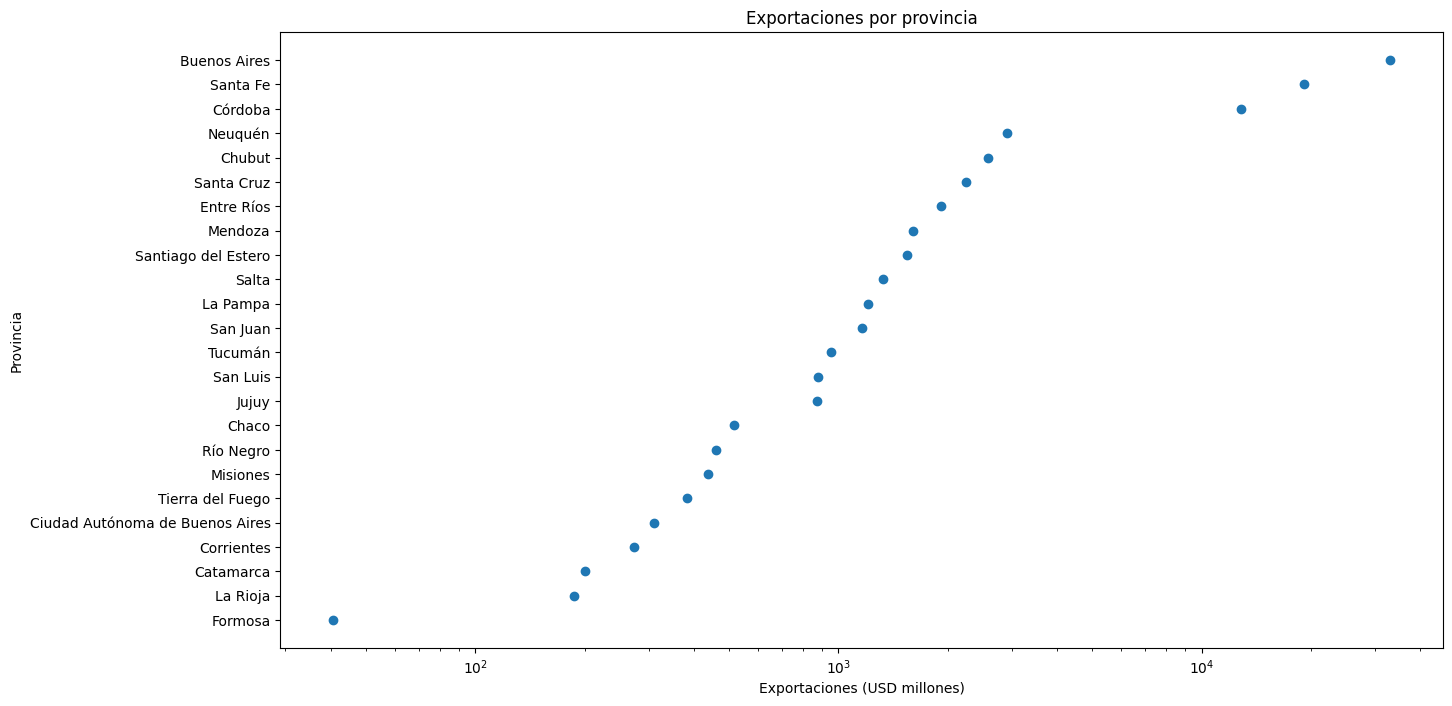

In [24]:
provincias_ordenadas = provincias.sort_values('exportaciones_usd_millones')

plt.figure(figsize=(15, 8))

plt.scatter(
    provincias_ordenadas.exportaciones_usd_millones, 
    provincias_ordenadas.provincia)
plt.xlabel('Exportaciones (USD millones)')
plt.ylabel('Provincia')
plt.title('Exportaciones por provincia')

plt.xscale('log')


Separamos las provincias regiones para analizarlas.

In [25]:
provincias_cuyo.append('San Luis')

In [26]:
provincias_patagonia.append('Tierra del Fuego') 

In [27]:
provincias_central = ['Córdoba', 'Ciudad Autónoma de Buenos Aires', 'Buenos Aires']

In [28]:
provincias_litoral = ['Santa Fe', 'Entre Ríos', 'Corrientes', 
                      'Misiones', 'Chaco', 'Formosa']

In [29]:
provincias_norte = ['Jujuy', 'Salta', 'Tucumán', 'Santiago del Estero', 'Catamarca']

In [30]:
provincias[provincias.provincia.isin(provincias_litoral)]

,provincia,poblacion_miles,hogares_miles,ingresos_miles,tasa_desempleo,superficie_km2,exportaciones_usd_millones
3,Chaco,1044,321,22744468,6.5,99763.3,516.34
6,Corrientes,1197,205,30606036,3.6,89123.3,273.18
7,Entre Ríos,1252,431,40510249,6.4,78383.7,1911.90
8,Formosa,509,148,9586123,3.3,75488.3,40.61
13,Misiones,1003,342,29639104,3.3,29911.4,438.24
20,Santa Fe,3311,1215,135661847,5.4,133249.1,19162.52


In [31]:
norte = provincias[provincias.provincia.isin(provincias_norte)].set_index('provincia')
litoral = provincias[provincias.provincia.isin(provincias_litoral)].set_index('provincia')
cuyo = provincias[provincias.provincia.isin(provincias_cuyo)].set_index('provincia')
central = provincias[provincias.provincia.isin(provincias_central)].set_index('provincia')
patagonia = provincias[provincias.provincia.isin(provincias_patagonia)].set_index('provincia')

In [32]:
regiones = [norte, litoral, cuyo, central, patagonia]

In [34]:
total_hogares = provincias.hogares_miles.sum()
total_ingresos = provincias.ingresos_miles.sum()

regiones_nombres = ['Norte', 'Litoral', 'Cuyo', 'Central', 'Patagonia']

index_regiones = len(regiones)

In [35]:
proporcion_hogares = []
proporcion_ingresos = []

for region in regiones:
        hogares_region = region.hogares_miles.sum() / total_hogares
        ingresos_region = region.ingresos_miles.sum() / total_ingresos
        proporcion_hogares.append(hogares_region)
        proporcion_ingresos.append(ingresos_region)

proporcion_desempleo = \
    [region.tasa_desempleo.sum().round(2) 
    for region in regiones]

## Porporciones de hogares, ingresos y tasa de desempleo por provincia

Text(0.02, 0.5, 'Porcentajes')

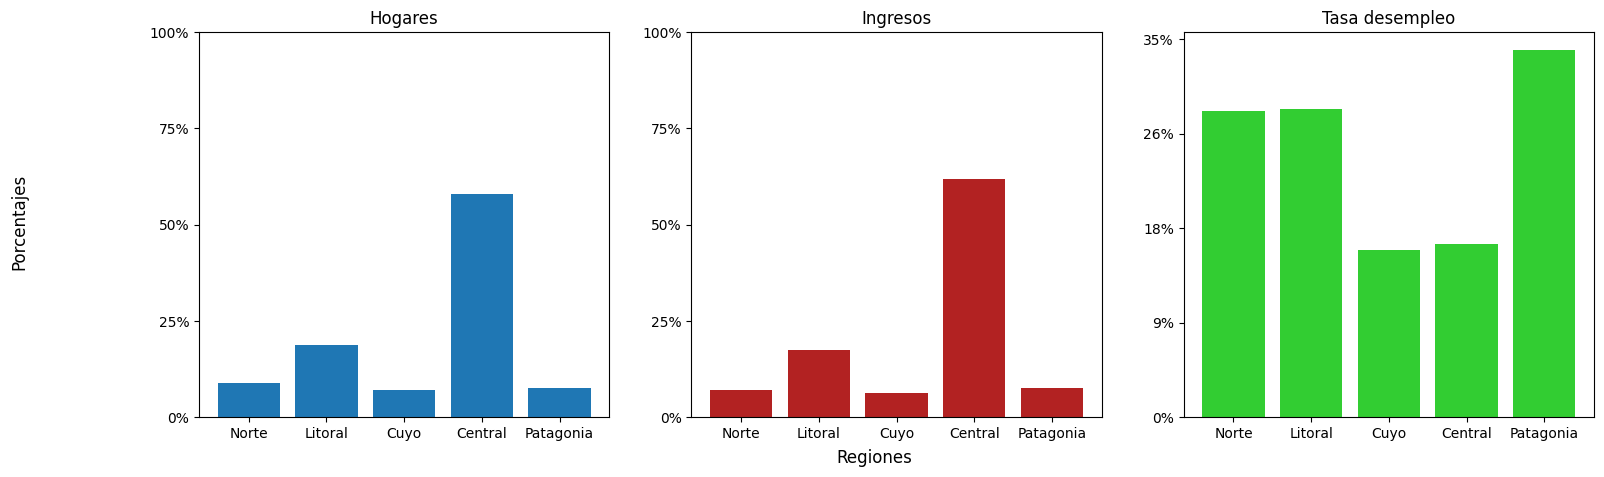

In [36]:
figs, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(regiones_nombres, proporcion_hogares)
axs[0].set_title('Hogares')
axs[0].set_yticks(np.linspace(0, 1, 5))
axs[0].set_yticklabels(
    [f'{val * 100:.0f}%' for val in axs[0].get_yticks()])



axs[1].bar(regiones_nombres, proporcion_ingresos, color='firebrick')
axs[1].set_title('Ingresos')
axs[1].set_yticks(np.linspace(0, 1, 5))
axs[1].set_yticklabels(
    [f'{val * 100:.0f}%' for val in axs[1].get_yticks()])


axs[2].bar(regiones_nombres, proporcion_desempleo, color='limegreen')
axs[2].set_title('Tasa desempleo')
axs[2].set_yticks(np.linspace(0, 35, 5))
axs[2].set_yticklabels(
    [f'{val:.0f}%' for val in axs[2].get_yticks()]
)


figs.supxlabel('Regiones')
figs.supylabel('Porcentajes')


## Exportación a Parquet

In [37]:
provincias.to_parquet('provincias.parquet')

# Conclusiones